# Comparison of GCN and GAT classifiers
Here, we want to compare the Graph Convolutional Network (GCN) classifier and the Graph Attention Network (GAT) classifier, for the response prediction. According to previous notebooks (`predict-response.ipynb` and `comparisons.ipynb`), we use sigmut + other biomarkers, without normalization of sigmut, and we build a pre-graph with tumour type, pruned with euclidean distance (for GCN).

# Table of contents

0. [Reading dataset](#0-reading-dataset)
1. [GCN classifier](#1-gcn-classifier)
2. [GAT classifier](#2-gat-classifier)
3. [Compare models](#3-compare-models)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager
from manage.GATClassifierTrainTestManager import GATClassifierTrainTestManager

from models.GCNClassifier import GCNClassifier
from models.GATClassifier import GATClassifier

from utils.preProcessing import preProcessing

from sklearn.preprocessing import StandardScaler

## 0. Reading dataset

In [2]:
## GCN classifier
df_gcn = pd.read_excel('data/table-s1-sigmut-indel.xlsx')
df_gcn = df_gcn.loc[df_gcn["Cohort"] == "Naive"]
df_gcn = preProcessing.delete_nan_values(df_gcn)

## GAT classifier
df_gat = pd.read_excel('data/table-s1-sigmut-indel.xlsx')
df_gat = df_gat.loc[df_gat["Cohort"] == "Naive"]
df_gat = preProcessing.delete_nan_values(df_gat)

In [3]:
features_name = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]
label_name = "Clinical benefit"
n_epochs = 25

## 1. GCN classifier
We build a pre-graph per tumour type, we normalize all data except mutational signatures, and we use the euclidean distance.

##### Select features

In [4]:
# Select features
features_to_normalize = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df_gcn.loc[:,features_to_normalize] = StandardScaler().fit_transform(df_gcn.loc[:,features_to_normalize].to_numpy())

# Extract features
X_gcn = df_gcn.loc[:,features_name].to_numpy()

# Numerize label
y_gcn = np.where(df_gcn[label_name]=="DCB",1,0)

##### Instanciate classifier

In [5]:
# Instanciate GCN classifier
gcn_clf = GCNClassifier(len(features_name))

# Instanciate the GCN train-test manager
gcn_manager = GCNClassifierTrainTestManager(gcn_clf)

##### Train classifier

In [6]:
## Group (tumour type) to build pre-graph
group_gcn = df_gcn["Tumour type"].to_numpy()

## Leave one out CV
test_scores_gcn, test_classes_gcn, train_loss_gcn, val_loss_gcn, std_train_loss_gcn, std_val_loss_gcn, params_conv_gcn,params_linear_gcn = gcn_manager.leave_one_out_cross_validation(X_gcn, y_gcn, group_gcn, n_epochs, "euclidean", 3)

In [7]:
# Take the absolute value
weights_conv_gcn = np.absolute(np.mean(params_conv_gcn[0].detach().numpy(),axis=1))
weights_linear_gcn= np.absolute(params_linear_gcn[0].detach().numpy())[0]

Text(0.5, 1.0, 'FC weights - GCN')

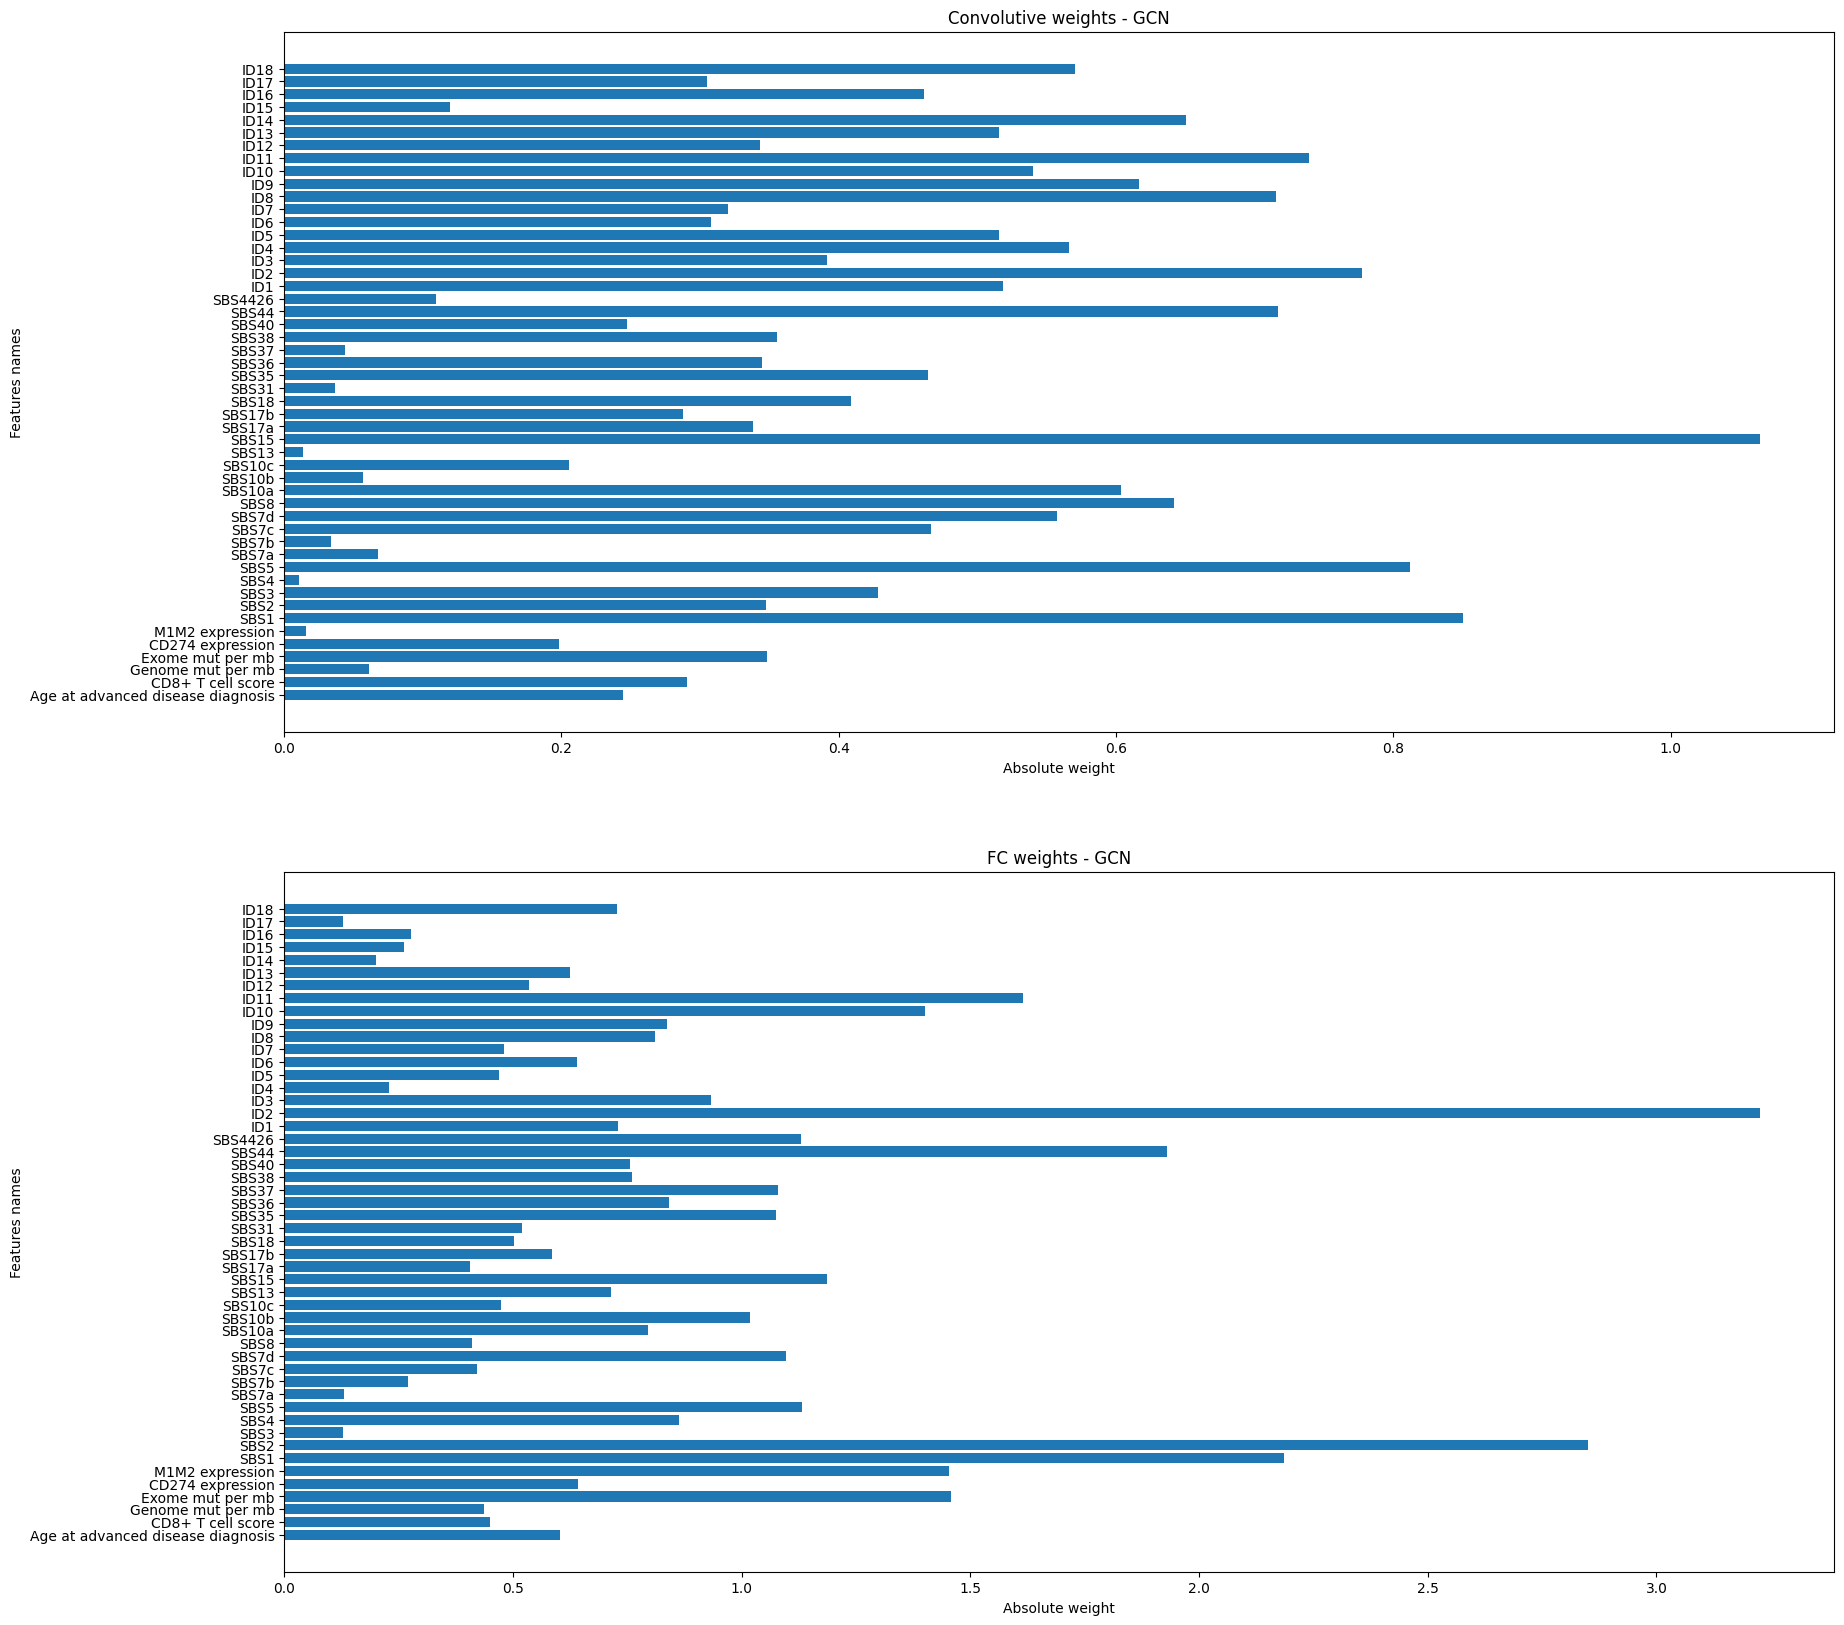

In [8]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

ax[0].barh(features_name,weights_conv_gcn)
ax[0].set_ylabel("Features names")
ax[0].set_xlabel("Absolute weight")
ax[0].set_title("Convolutive weights - GCN")

ax[1].barh(features_name,weights_linear_gcn)
ax[1].set_ylabel("Features names")
ax[1].set_xlabel("Absolute weight")
ax[1].set_title("FC weights - GCN")

## 2. GAT classifier

#### Select features

In [9]:
# Select features
features_to_normalize = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df_gat.loc[:,features_to_normalize] = StandardScaler().fit_transform(df_gat.loc[:,features_to_normalize].to_numpy())

# Extract features
X_gat = df_gat.loc[:,features_name].to_numpy()

# Numerize label
y_gat = np.where(df_gat[label_name]=="DCB",1,0)

#### Instanciate classifier

In [10]:
# Instanciate GCN classifier
gat_clf = GATClassifier(len(features_name))

# Instanciate the GCN train-test manager
gat_manager = GATClassifierTrainTestManager(gat_clf)

#### Train classifier

In [11]:
## Group (tumour type) to build pre-graph
group_gat= df_gat["Tumour type"].to_numpy()

## Leave one out CV
test_scores_gat, test_classes_gat, train_loss_gat, val_loss_gat, std_train_loss_gat, std_val_loss_gat, params_attention_gat, params_conv_gat,params_linear_gat = gat_manager.leave_one_out_cross_validation(X_gat, y_gat, group_gat, n_epochs)

In [12]:
# Take the absolute value
weights_attention_gat = np.absolute(np.mean(params_attention_gat[0].detach().numpy(),axis=1))
weights_conv_gat = np.absolute(np.mean(params_conv_gat[0].detach().numpy(),axis=1))
weights_linear_gat= np.absolute(params_linear_gat[0].detach().numpy())[0]

Text(0.5, 1.0, 'FC weights - GAT')

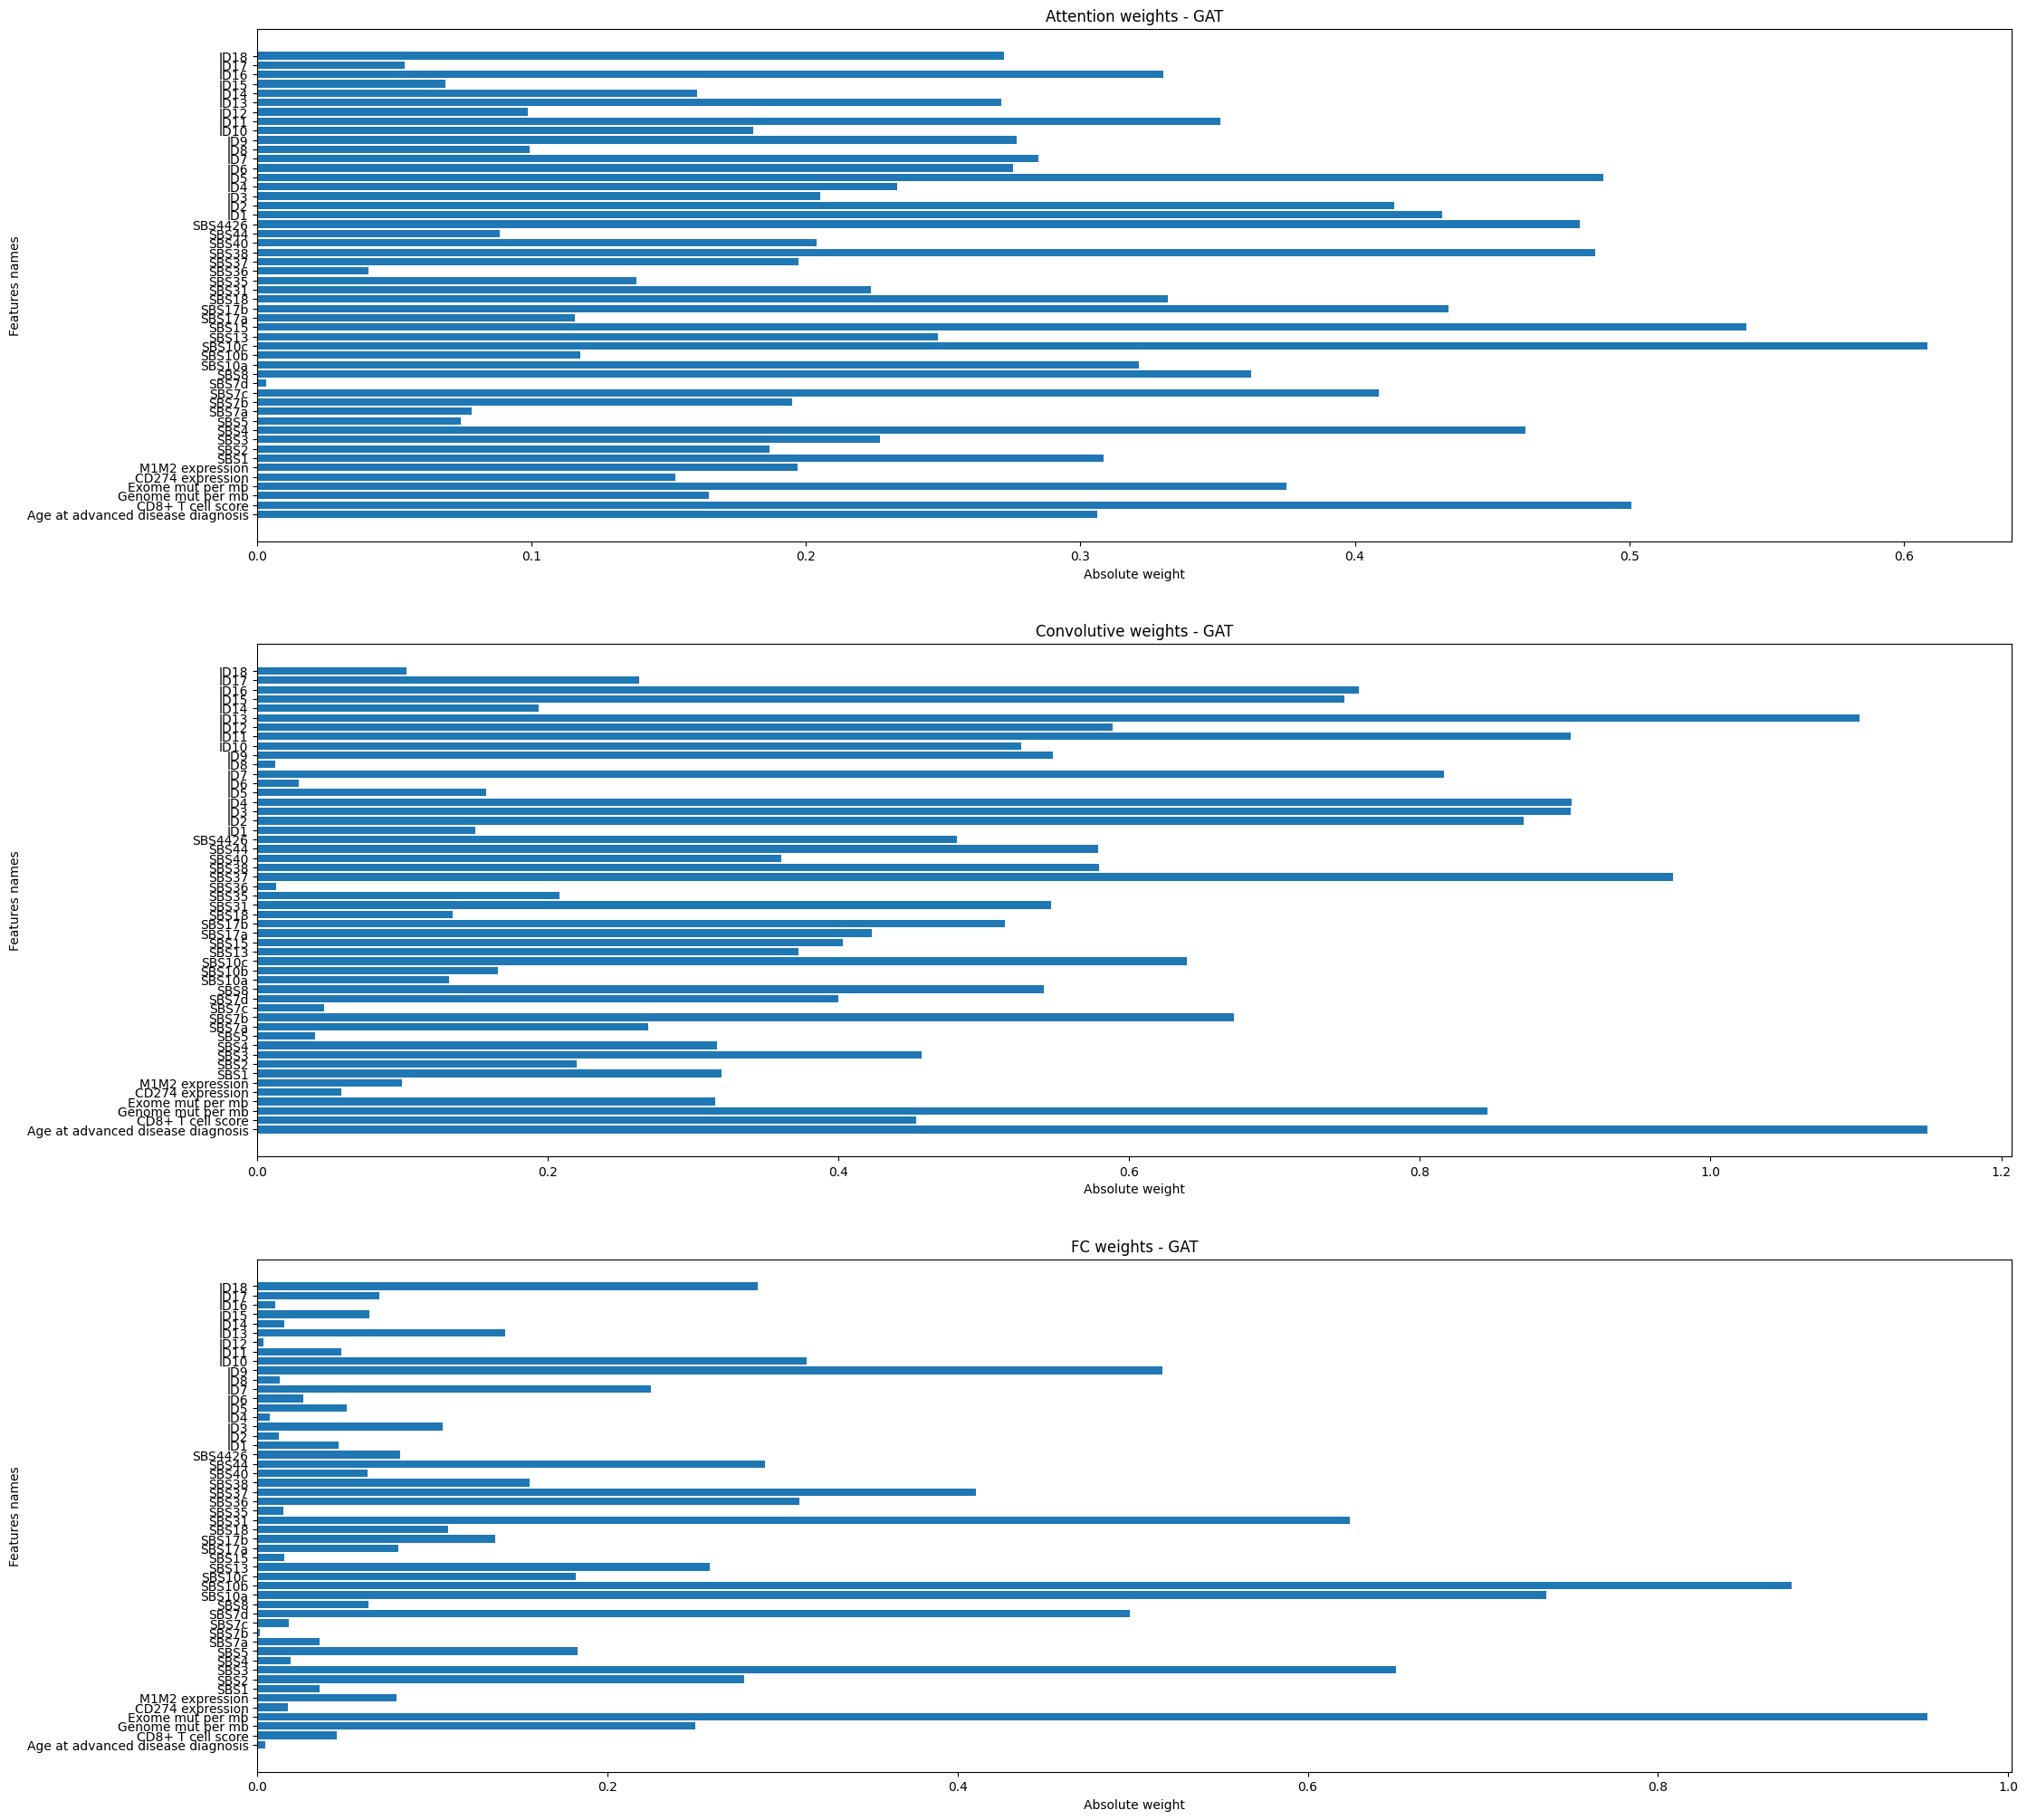

In [13]:
fig, ax = plt.subplots(3,1,figsize=(25,25))

ax[0].barh(features_name,weights_attention_gat)
ax[0].set_ylabel("Features names")
ax[0].set_xlabel("Absolute weight")
ax[0].set_title("Attention weights - GAT")

ax[1].barh(features_name,weights_conv_gat)
ax[1].set_ylabel("Features names")
ax[1].set_xlabel("Absolute weight")
ax[1].set_title("Convolutive weights - GAT")

ax[2].barh(features_name,weights_linear_gat)
ax[2].set_ylabel("Features names")
ax[2].set_xlabel("Absolute weight")
ax[2].set_title("FC weights - GAT")

## 3. Compare models

In [14]:
## GCN classifier
pre_gcn, rec_gcn, f1_gcn = ClassificationMetrics.eval_metrics_from_conf_matrix(y_gcn, test_classes_gcn)
fpr_gcn, tpr_gcn, thresholds_gcn = ClassificationMetrics.compute_roc_curve(y_gcn, test_scores_gcn)
auc_gcn = ClassificationMetrics.compute_auc(y_gcn, test_scores_gcn)

## GAT classifier
pre_gat, rec_gat, f1_gat = ClassificationMetrics.eval_metrics_from_conf_matrix(y_gat, test_classes_gat)
fpr_gat, tpr_gat, thresholds_gat = ClassificationMetrics.compute_roc_curve(y_gat, test_scores_gat)
auc_gat = ClassificationMetrics.compute_auc(y_gat, test_scores_gat)

Text(0.5, 1.0, 'GAT (test set)')

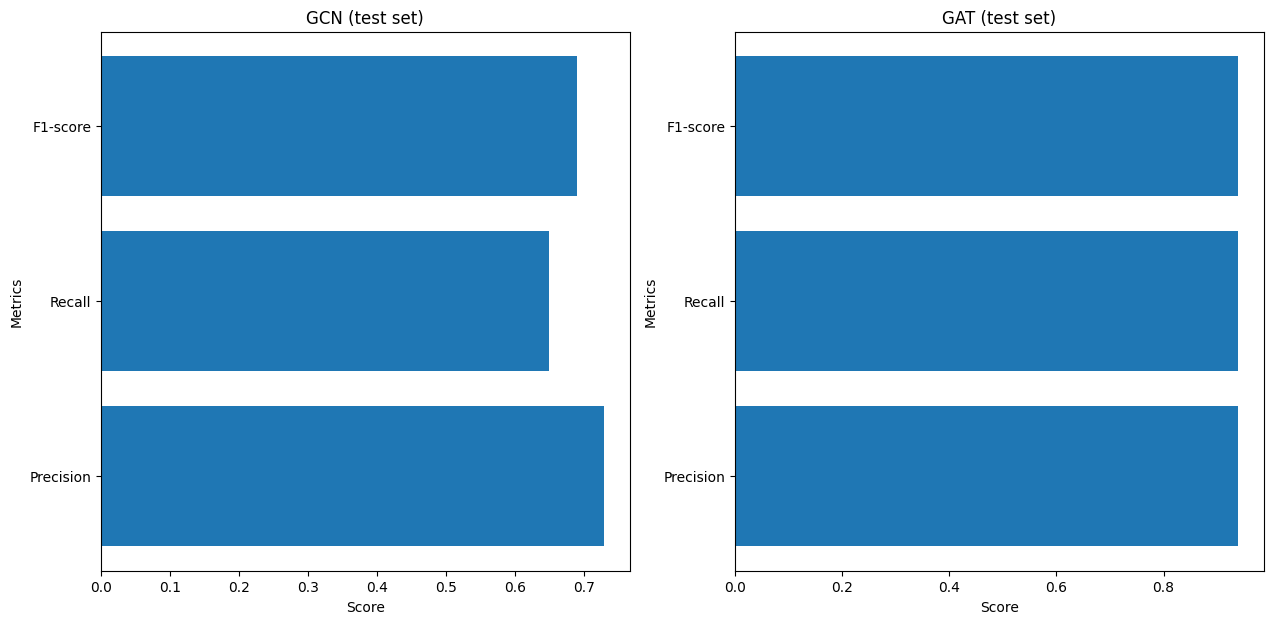

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].barh(["Precision","Recall","F1-score"],[pre_gcn, rec_gcn, f1_gcn])
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Metrics")
ax[0].set_title("GCN (test set)")

ax[1].barh(["Precision","Recall","F1-score"],[pre_gat, rec_gat, f1_gat])
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Metrics")
ax[1].set_title("GAT (test set)")

Text(0, 0.7, 'AUC GAT : 1.0')

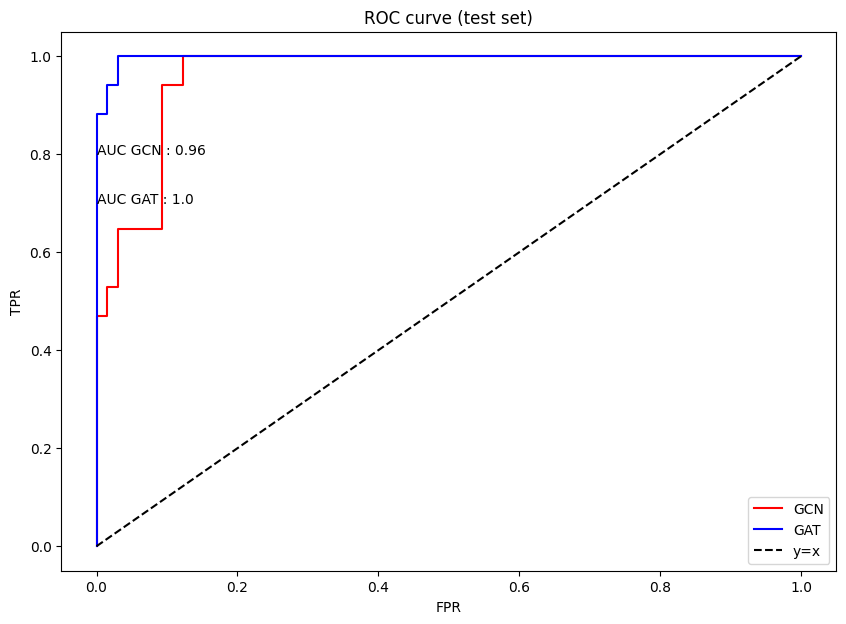

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0,1,100)

ax.plot(fpr_gcn, tpr_gcn, color='red',label='GCN')
ax.plot(fpr_gat, tpr_gat, color='blue',label='GAT')
ax.plot(x,x,linestyle='--',color='black',label='y=x')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve (test set)')
ax.legend()
ax.text(0,0.8,f"AUC GCN : {auc_gcn}")
ax.text(0,0.7,f"AUC GAT : {auc_gat}")

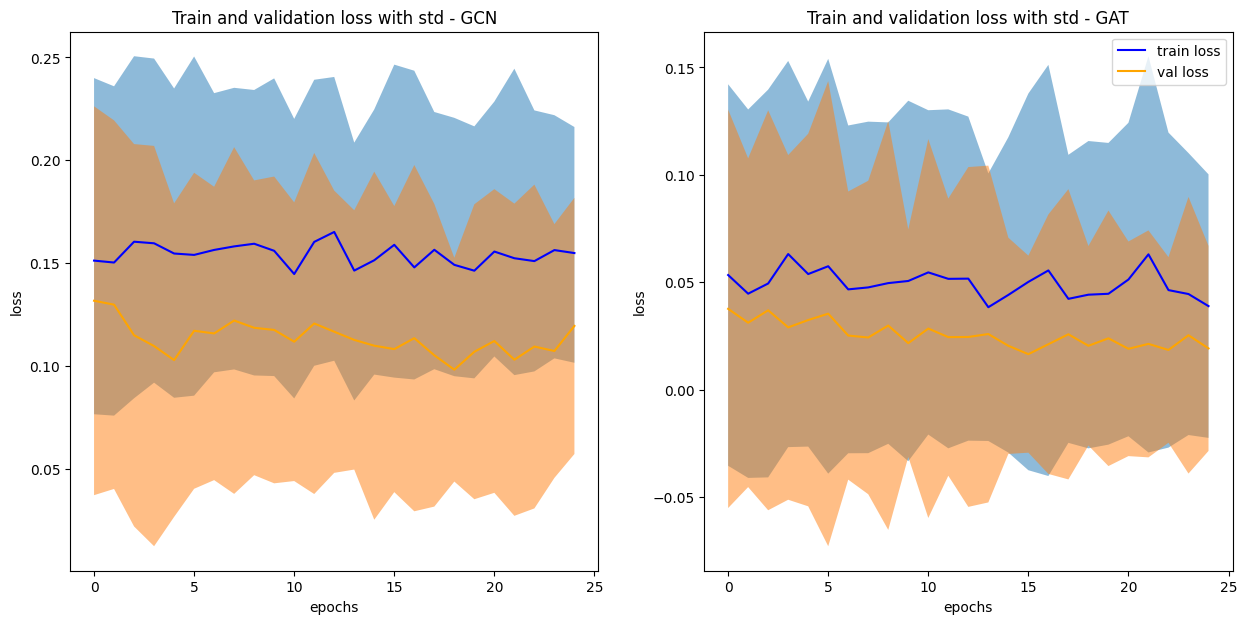

In [17]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(1,2,figsize=(15,7))

# GCN :
ax[0].plot(epochs, train_loss_gcn, color='blue',label='train loss')
ax[0].fill_between(epochs, train_loss_gcn-std_train_loss_gcn, train_loss_gcn+std_train_loss_gat, alpha=0.5)
ax[0].plot(epochs, val_loss_gcn, color='orange',label='val loss')
ax[0].fill_between(epochs, val_loss_gcn-std_val_loss_gcn, val_loss_gcn+std_val_loss_gcn,alpha=0.5)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('Train and validation loss with std - GCN')

# GAT :
ax[1].plot(epochs, train_loss_gat, color='blue',label='train loss')
ax[1].fill_between(epochs, train_loss_gat-std_train_loss_gat, train_loss_gat+std_train_loss_gat, alpha=0.5)
ax[1].plot(epochs, val_loss_gat, color='orange',label='val loss')
ax[1].fill_between(epochs, val_loss_gat-std_val_loss_gat, val_loss_gat+std_val_loss_gat,alpha=0.5)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Train and validation loss with std - GAT')

plt.legend()